In [6]:
import numpy as np
import random
import axelrod as axl
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pandas as pd
import pickle
import os


In [2]:
# Strategies
from axelrod import strategies

STRATS = strategies
m = len(STRATS)
print(f"Found {m} strategies:", [cls.__name__ for cls in STRATS])


Found 240 strategies: ['ALLCorALLD', 'AON2', 'APavlov2006', 'APavlov2011', 'Adaptive', 'AdaptiveTitForTat', 'AdaptorBrief', 'AdaptorLong', 'Aggravater', 'Alexei', 'Alternator', 'AlternatorHunter', 'AntiCycler', 'AntiTitForTat', 'Appeaser', 'ArrogantQLearner', 'AverageCopier', 'BackStabber', 'BetterAndBetter', 'Bully', 'BurnBothEnds', 'BushMosteller', 'Calculator', 'Capri', 'CautiousQLearner', 'CollectiveStrategy', 'ContriteTitForTat', 'Cooperator', 'CooperatorHunter', 'CycleHunter', 'CyclerCCCCCD', 'CyclerCCCD', 'CyclerCCCDCD', 'CyclerCCD', 'CyclerDC', 'CyclerDDC', 'DBS', 'Defector', 'DefectorHunter', 'DelayedAON1', 'Desperate', 'Detective', 'DoubleCrosser', 'DoubleResurrection', 'Doubler', 'DynamicTwoTitsForTat', 'EasyGo', 'EugineNier', 'EventualCycleHunter', 'EvolvedANN', 'EvolvedANN5', 'EvolvedANNNoise05', 'EvolvedFSM16', 'EvolvedFSM16Noise05', 'EvolvedFSM4', 'EvolvedFSM6', 'EvolvedHMM5', 'EvolvedLookerUp1_1_1', 'EvolvedLookerUp2_2_2', 'FirmButFair', 'FirstByAnonymous', 'FirstByDavi

In [ ]:
# COMPUTING THE PAYOFF-MATRIX

# ─── 1) Simulation parameters ────────────────────────────────────────────
m      = len(STRATS)
turns  = 400
rounds = 10000
N      = 240
n_reps = 30
noise_levels = [1e-4, 1e-3, 1e-2]

# 2) Build the list of unique (i,j) pairs i ≤ j
pairs = [(i, j) for i in range(m) for j in range(i, m)]
chunk_size = 100
blocks = [pairs[k:k + chunk_size] for k in range(0, len(pairs), chunk_size)]

# 3) Make payoff_block accept a noise parameter
def payoff_block(block, ipd_noise):
    out = []
    for i, j in block:
        # instantiate and play with execution-noise = ipd_noise
        match = axl.Match([STRATS[i](), STRATS[j]()],
                          turns=turns,
                          noise=ipd_noise)
        match.play()
        a_score, b_score = match.final_score()
        out.append((i, j, a_score, b_score))
    return out

# 4) Loop over your noise levels
FULL_P_matrices = {}
for ε in noise_levels:
    # parallel runs of payoff_block, passing ε through
    results = Parallel(n_jobs=-1)(
        delayed(payoff_block)(block, ε) for block in blocks
    )

    # assemble the symmetric payoff matrix
    FULL_P = np.zeros((m, m), dtype=float)
    for block_res in results:
        for i, j, a_score, b_score in block_res:
            FULL_P[i, j] = a_score
            FULL_P[j, i] = b_score

    # store & optionally cache to disk
    FULL_P_matrices[ε] = FULL_P
    with open(f'FULL_P_noise_{ε:.0e}.pkl', 'wb') as f:
        pickle.dump(FULL_P, f)

# now FULL_P_matrices[1e-3] is your payoff matrix built with 0.001 action-flip noise, etc.


In [7]:
# LOADING THE PAYOFF MATRIX WITHOUT HAVING TO COMPUTE IT AGAIN

# ─── 1) Simulation parameters ────────────────────────────────────────────
m      = len(STRATS)
turns  = 400
rounds = 10000
N      = 240
n_reps = 30
noise_levels = [1e-4, 1e-3, 1e-2]
noise_levels = [1e-4, 1e-3, 1e-2]
FULL_P_matrices = {}

for eps in noise_levels:
    fname = f'FULL_P_noise_{eps:.0e}.pkl'
    if os.path.exists(fname):
        # load from disk
        with open(fname, 'rb') as f:
            FULL_P_matrices[eps] = pickle.load(f)
        print(f"Loaded FULL_P for noise={eps} from {fname}")
    else:
        print(f"No cache found for noise={eps} (file {fname} not present)")


Loaded FULL_P for noise=0.0001 from FULL_P_noise_1e-04.pkl
Loaded FULL_P for noise=0.001 from FULL_P_noise_1e-03.pkl
Loaded FULL_P for noise=0.01 from FULL_P_noise_1e-02.pkl


In [ ]:
# ─── Updated Moran‐process simulator ────────────────────────────────────────
def simulate_moran_numpy(seed, P, strat_list, N, rounds, mu):
    """
    Runs one stochastic birth–death Moran process
    over `rounds` generations with:
      • P: full payoff matrix (m×m)
      • mu: mutation probability
    """
    m   = len(strat_list)
    rng = np.random.default_rng(seed)

    # (a) Initialize counts uniformly at random
    counts = np.zeros(m, dtype=np.int64)
    for idx in rng.integers(m, size=N):
        counts[idx] += 1

    history = np.empty((rounds, m), dtype=np.int64)

    for t in range(rounds):
        # 1) Compute total payoffs vs. current population
        f = P.dot(counts)               # shape (m,)

        # 2) Fitness = abundance × payoff
        fitness = counts * f            # shape (m,)
        total_fitness = fitness.sum()
        if total_fitness > 0:
            repro_p = fitness / total_fitness
        else:
            repro_p = np.full(m, 1/m)

        # 3) Pick a parent by fitness
        i_rep = rng.choice(m, p=repro_p)

        # 4) Mutation: with prob. mu, child is random strategy
        if rng.random() < mu:
            i_rep = rng.integers(m)

        # 5) Pick one individual to die (uniform over all)
        i_die = rng.choice(m, p=counts / counts.sum())

        # 6) Birth–death update
        if i_rep != i_die:
            counts[i_rep] += 1
            counts[i_die]  -= 1

        # 7) Record the new counts
        history[t] = counts

    return history



In [10]:
# ─── Updated main simulation ────────────────────────────────────────────────
# pick which matrix you want
FULL_P = FULL_P_matrices[1e-3]

def main_simulation():
    grid_results = []
    mu_levels    = [1e-6, 1e-4, 1e-2]   # only sweep over mutation now

    for mu_val in mu_levels:
        # run n_reps independent Moran processes in parallel
        histories = Parallel(n_jobs=-1)(
            delayed(simulate_moran_numpy)(
                seed*100 + rep,   # unique RNG seed
                FULL_P,           # your (single) payoff matrix
                STRATS,           # list of m strategies
                N,
                rounds,
                mu_val            # only mutation
            )
            for rep, seed in enumerate(range(n_reps))
        )

        grid_results.append({
            'mutation': mu_val,
            'histories': histories
        })

    df = pd.DataFrame(grid_results)
    return df

# Run and inspect
df = main_simulation()
print(df)


   mutation                                          histories
0  0.000001  [[[1, 2, 0, 4, 0, 1, 2, 0, 1, 2, 0, 3, 1, 0, 1...
1  0.000100  [[[1, 2, 0, 4, 0, 1, 2, 0, 1, 2, 0, 3, 1, 0, 1...
2  0.010000  [[[1, 2, 0, 4, 0, 1, 2, 0, 1, 2, 0, 3, 1, 0, 1...


In [11]:
df = main_simulation()
print(df)

   mutation                                          histories
0  0.000001  [[[1, 2, 0, 4, 0, 1, 2, 0, 1, 2, 0, 3, 1, 0, 1...
1  0.000100  [[[1, 2, 0, 4, 0, 1, 2, 0, 1, 2, 0, 3, 1, 0, 1...
2  0.010000  [[[1, 2, 0, 4, 0, 1, 2, 0, 1, 2, 0, 3, 1, 0, 1...


In [12]:
from joblib import Parallel, delayed
import pandas as pd

def run_all( FULL_P_matrices, STRATS, N, rounds, n_reps, mu_levels ):
    records = []
    # FULL_P_matrices is a dict: ε → P_matrix
    for ε, P in FULL_P_matrices.items():
        for mu_val in mu_levels:
            # run n_reps replicates for this (ε, mu)
            histories = Parallel(n_jobs=-1)(
                delayed(simulate_moran_numpy)(
                    seed*100 + rep,
                    P,
                    STRATS,
                    N,
                    rounds,
                    mu_val
                )
                for rep, seed in enumerate(range(n_reps))
            )
            records.append({
                'ipd_noise':  ε,
                'mutation':   mu_val,
                'histories':  histories
            })
    return pd.DataFrame(records)

# your mutation sweep
mu_levels = [1e-6, 1e-4, 1e-2]

# suppose you already have FULL_P_matrices = {1e-4: P1, 1e-3: P2, 1e-2: P3}
df = run_all(FULL_P_matrices, STRATS, N, rounds, n_reps, mu_levels)

/var/folders/ct/svp4z3w13038vgsv02v2psmr0000gn/T/ipykernel_62148/2650572693.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap       = mpl.cm.get_cmap("tab20", num_series)


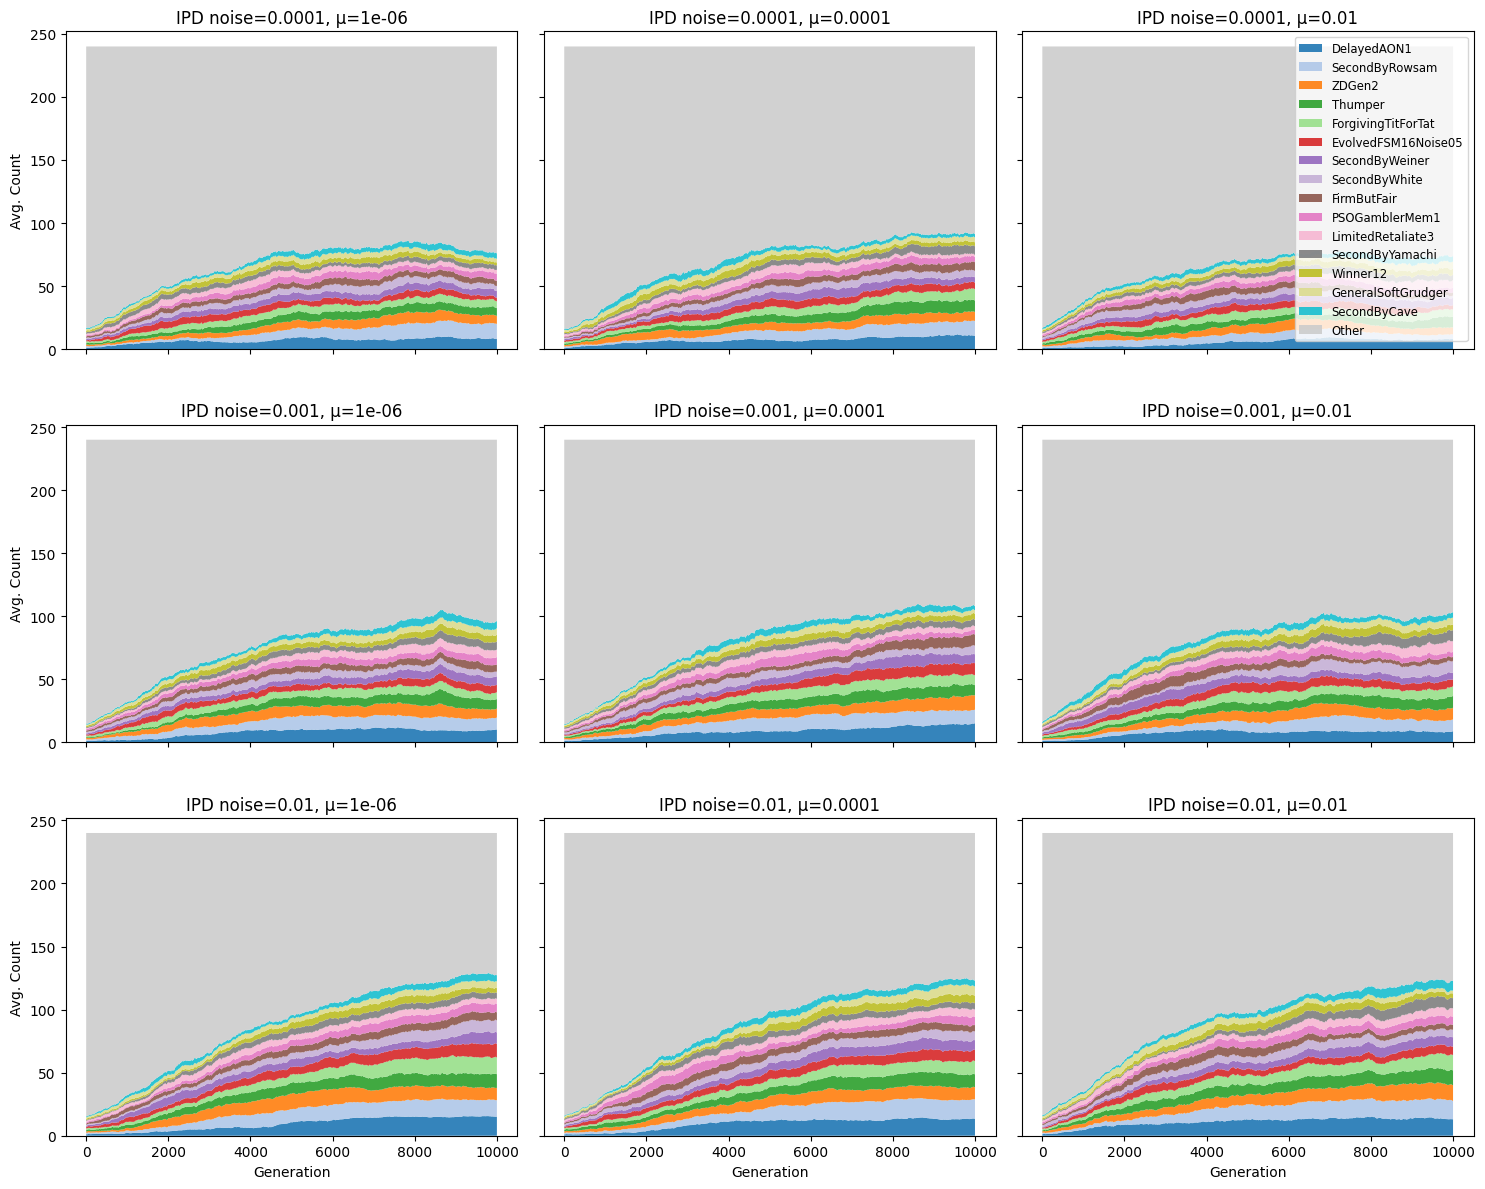

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

tmax = 10000

noise_levels = sorted(df['ipd_noise'].unique())
mu_levels    = sorted(df['mutation'].unique())
nrows, ncols = len(noise_levels), len(mu_levels)

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(5 * ncols, 4 * nrows),
                         sharex=True, sharey=True)

for i, ε in enumerate(noise_levels):
    for j, mu_val in enumerate(mu_levels):
        ax = axes[i, j] if (nrows > 1 and ncols > 1) else axes[max(i, j)]

        # grab the right row
        row       = df[(df['ipd_noise']==ε) & (df['mutation']==mu_val)].iloc[0]
        histories = row['histories']

        # stack, truncate, average
        arr        = np.stack(histories, axis=0)   # (n_reps, rounds, m)
        arr        = arr[:, :tmax, :]              # (n_reps, tmax, m)
        avg_counts = arr.mean(axis=0)              # (tmax, m)

        # pick top-N strategies by their overall average
        mean_over_time = avg_counts.mean(axis=0)
        top_n = 15
        top_idx = np.argsort(mean_over_time)[-top_n:][::-1]

        plot_main = avg_counts[:, top_idx].T       # (top_n, tmax)
        other     = avg_counts[:, 
                      [k for k in range(avg_counts.shape[1]) if k not in top_idx]
                     ].sum(axis=1)
        plot_data = np.vstack([plot_main, other])  # (top_n+1, tmax)

        labels = [STRATS[k].__name__ for k in top_idx] + ['Other']

        # color‐cycle
        num_series = plot_data.shape[0]
        cmap       = mpl.cm.get_cmap("tab20", num_series)
        colors     = [cmap(idx) for idx in range(num_series)]
        colors[-1] = (0.8,0.8,0.8,1.0)

        domain = np.arange(tmax)
        ax.stackplot(domain, plot_data, labels=labels,
                     colors=colors, alpha=0.9)

        ax.set_title(f"IPD noise={ε}, μ={mu_val:g}")
        if i == nrows - 1:
            ax.set_xlabel("Generation")
        if j == 0:
            ax.set_ylabel("Avg. Count")
        # only one legend in the top‐right corner
        if i == 0 and j == ncols - 1:
            ax.legend(loc="upper right", fontsize="small", ncol=1)

plt.tight_layout()
plt.show()


/var/folders/ct/svp4z3w13038vgsv02v2psmr0000gn/T/ipykernel_44486/2321006272.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = mpl.cm.get_cmap("tab20", top_n+1)


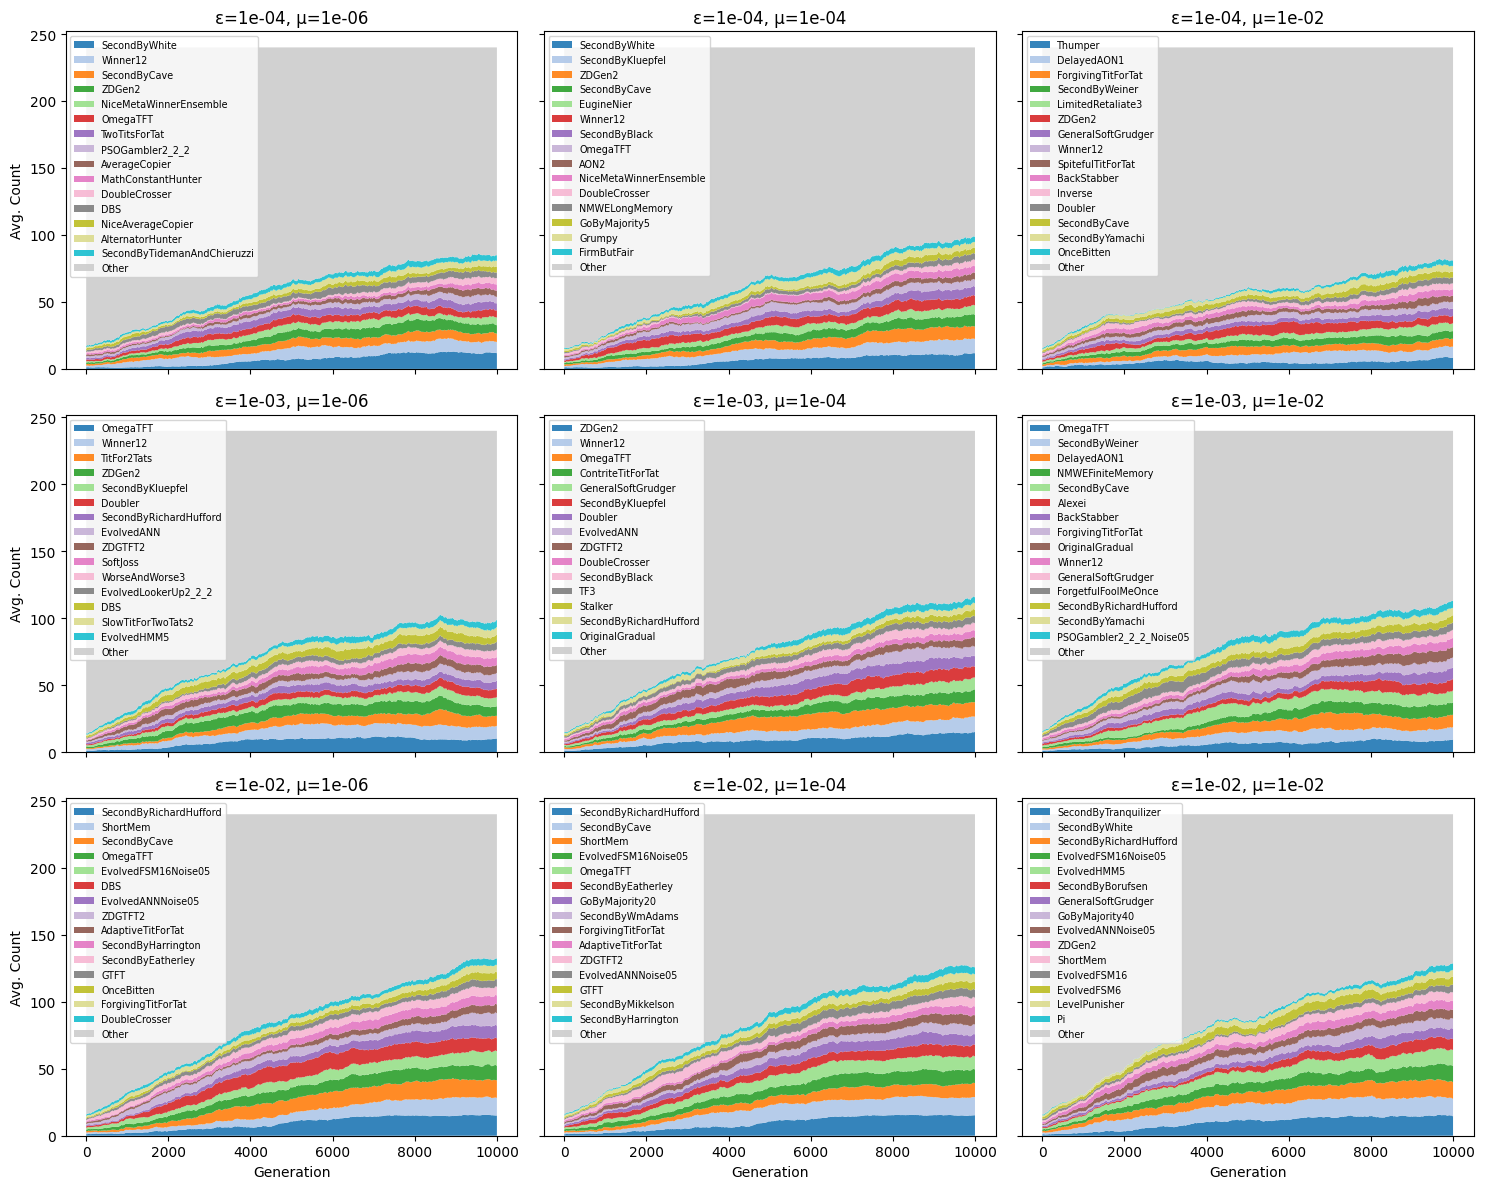

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# how many gens to plot
tmax  = 10000  
# how many “top” strategies per panel
top_n = 15

# grab your two sweep axes
ipd_noise_levels = sorted(df['ipd_noise'].unique())
mu_levels        = sorted(df['mutation'].unique())

nrows, ncols = len(ipd_noise_levels), len(mu_levels)

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(5 * ncols, 4 * nrows),
                         sharex=True, sharey=True)

for i, eps in enumerate(ipd_noise_levels):
    for j, mu in enumerate(mu_levels):
        # select the right Axes
        ax = axes[i, j] if (nrows>1 and ncols>1) else axes[max(i,j)]
        
        # pull out that cell from the df
        row       = df[(df['ipd_noise']==eps) & (df['mutation']==mu)].iloc[0]
        histories = row['histories']   # list of (rounds×m) arrays
        
        # stack, truncate, and average
        arr        = np.stack(histories, axis=0)  # (n_reps, rounds, m)
        arr        = arr[:, :tmax, :]             # keep 0:tmax
        avg_counts = arr.mean(axis=0)             # (tmax, m)
        
        # pick the top_n by _final_ abundance
        final_means = avg_counts[-1, :]           # abundance at tmax-1  
        top_idx     = np.argsort(final_means)[-top_n:][::-1]
        
        # build the data to plot: top_n series + “Other”
        main_data = avg_counts[:, top_idx].T       # (top_n, tmax)
        other     = avg_counts[:, [k for k in range(avg_counts.shape[1]) 
                                  if k not in top_idx]].sum(axis=1)
        plot_data = np.vstack([main_data, other])  # (top_n+1, tmax)
        
        # labels
        labels = [STRATS[k].__name__ for k in top_idx] + ['Other']
        
        # colors
        cmap   = mpl.cm.get_cmap("tab20", top_n+1)
        colors = [cmap(ii) for ii in range(top_n+1)]
        colors[-1] = (0.8,0.8,0.8,1.0)  # grey for “Other”
        
        # do the stackplot
        domain = np.arange(tmax)
        ax.stackplot(domain, plot_data, labels=labels,
                     colors=colors, alpha=0.9)
        
        # annotate
        ax.set_title(f"ε={eps:.0e}, μ={mu:.0e}")
        if i == nrows-1: ax.set_xlabel("Generation")
        if j == 0:       ax.set_ylabel("Avg. Count")
        
        # a small legend per panel
        ax.legend(loc="upper left", fontsize="x-small", ncol=1)

plt.tight_layout()
plt.show()


In [14]:
import numpy as np
import pandas as pd

# Parameters
ipd_noises = sorted(df['ipd_noise'].unique())
mu_levels  = sorted(df['mutation'].unique())
N          = 240    # your population size
n_reps     = len(df.loc[(df['ipd_noise']==ipd_noises[0]) & 
                        (df['mutation']==mu_levels[0]), 'histories'].iloc[0])

# 1) Loop over every (ε, μ) and every strategy to get mean & SEM
records = []
for eps in ipd_noises:
    for mu in mu_levels:
        row = df[(df['ipd_noise']==eps) & (df['mutation']==mu)].iloc[0]
        histories = row['histories']               # list of arrays (rounds×m)
        
        # stack replicates and take final generation
        arr         = np.stack(histories, axis=0)  # shape=(n_reps, rounds, m)
        final_counts= arr[:, -1, :]                # (n_reps, m)
        
        # convert to percentages
        final_pct   = final_counts / N * 100       # (n_reps, m)
        
        # compute mean & SEM for each strategy
        for idx, strat in enumerate(STRATS):
            vec = final_pct[:, idx]
            mean = vec.mean()
            sem  = vec.std(ddof=1) / np.sqrt(n_reps)
            records.append({
                'ipd_noise': eps,
                'mutation':  mu,
                'strategy':  strat.__name__,
                'mean_pct':  mean,
                'sem_pct':   sem
            })

stats_df = pd.DataFrame(records)

# 2) (Optional) pull out just the top-5 for each (ε,μ)
top5_records = []
for (eps, mu), group in stats_df.groupby(['ipd_noise','mutation']):
    top5 = group.nlargest(5, 'mean_pct')
    top5_records.append(top5)
top5_df = pd.concat(top5_records).reset_index(drop=True)

# 3) Display as a table
print("Top-5 final frequencies (mean ± SEM %):")
print(top5_df[['ipd_noise','mutation','strategy','mean_pct','sem_pct']].to_string(index=False))


Top-5 final frequencies (mean ± SEM %):
 ipd_noise  mutation               strategy  mean_pct  sem_pct
    0.0001  0.000001          SecondByWhite  4.902778 2.545223
    0.0001  0.000001               Winner12  3.416667 2.011739
    0.0001  0.000001           SecondByCave  2.611111 1.294072
    0.0001  0.000001                 ZDGen2  2.611111 1.633523
    0.0001  0.000001 NiceMetaWinnerEnsemble  2.402778 1.798174
    0.0001  0.000100          SecondByWhite  4.875000 2.533866
    0.0001  0.000100       SecondByKluepfel  4.486111 2.550158
    0.0001  0.000100                 ZDGen2  3.847222 2.744995
    0.0001  0.000100           SecondByCave  3.638889 1.864989
    0.0001  0.000100             EugineNier  2.930556 2.030900
    0.0001  0.010000                Thumper  3.513889 1.610114
    0.0001  0.010000            DelayedAON1  3.388889 2.532021
    0.0001  0.010000     ForgivingTitForTat  2.472222 2.332678
    0.0001  0.010000      LimitedRetaliate3  2.361111 1.613042
    0.0001  0.0